# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jacfwd, jit
import jax
import copy

In [2]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    i_arr = []
    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            i_arr.append(int(ind))
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([i_arr, x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

In [3]:
def g2oWrite(newFile, origFile, verts):
    fnew = open(newFile, 'w')
    
    for i in range(len(verts[0])):
        fnew.write('VERTEX_SE2 {} {} {} {}\n'.format(int(verts[0][i]), verts[1][i], verts[2][i], verts[3][i]))
    
    forig = open(origFile, 'r')
    lines = forig.readlines()
    for line in lines[1:]:
        fnew.write(line)
    
    forig.close()
    fnew.close()

In [4]:
def draw(X, Y, THETA, ax, color='g->'):
    ax.plot(X, Y, 'ro')
    ax.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], color)

In [5]:
def getPoses(verts, edges, odo=True):
    proc = copy.deepcopy(verts[:, :])
    preds = copy.deepcopy(verts[:, :])
    
    while proc.shape[1]:
        curr = proc[:, 0]
        currParam = curr[1:]
        currEdges = jnp.where(edges[0] == curr[0])[0]
        
        if(not len(currEdges)):
            break
            
        for i in range(len(currEdges)):
            to = edges[1][currEdges[i]]
            
            if(odo and to != curr[0] + 1):
                continue
            
            elif(not odo and to == curr[0] + 1):
                continue
                
            delParam = [edges[2][currEdges[i]], edges[3][currEdges[i]], edges[4][currEdges[i]]]
            nextPose = jnp.array([[to],
                        [currParam[0] + delParam[0] * jnp.cos(currParam[2]) - delParam[1] * jnp.sin(currParam[2])],
                        [currParam[1] + delParam[1] * jnp.cos(currParam[2]) + delParam[0] * jnp.sin(currParam[2])],
                        [currParam[2] + delParam[2]]])
            #print(odo, proc, curr, to, delParam, currParam, nextPose)
            
            if(to not in preds[0] and odo):
                proc[:, 0] = [*nextPose[:]]
                
            else:
                proc = proc[:, 1:]
            
            preds = jnp.hstack([preds, nextPose])
            
    preds = preds[:, verts.shape[1]:]
    preds = preds[:, preds[0].argsort()]
    return preds

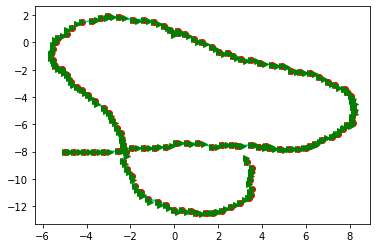

In [6]:
verts = np.array(readVertex('../data/edges.txt'))
initInd = verts[0]
anchor = np.reshape(verts[1:, 0], (3, 1))
edges = np.array(readEdge('../data/edges.txt'))
poses = np.hstack([np.reshape(verts[:, 0], (4, 1)), getPoses(verts, edges)])

g2oWrite('edges-poses.g2o', '../data/edges.txt', poses)
ax = plt.subplot(111)
draw(poses[1], poses[2], poses[3], ax)
plt.show()

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [23]:
def getOmega(wts=[500, 700, 1000]):
    inf_i = [wts[0]] * 3 * poses.shape[1]
    inf_ij = [wts[1]] * 3 * np.where(edges[1] != edges[0] + 1)[0].shape[0]
    inf = [*inf_i, *inf_ij]
    inf[0:3] = [wts[2]] * 3
    omega = np.diag(inf)
    omega = jnp.array(omega)
    
    return omega

In [8]:
def myJacob(params, initInd, edges):
    J = np.zeros((3 * (1 + edges.shape[1]), len(params)))
    
    J[0][0] = 1
    J[1][1] = 1
    J[2][2] = 1
    for i in range(edges.shape[1]):
        for j in range(3):
            J[3 * (1 + i) + j][3 * int(edges[1][i]) + j] = -1
            J[3 * (1 + i) + j][3 * int(edges[0][i]) + j] = 1
        
        thetaInd = 3 * int(edges[0][i]) + 2
        J[3 * (1 + i)][thetaInd] = -(edges[2][i] * np.sin(params[thetaInd]) + edges[3][i] * np.cos(params[thetaInd]))
        J[3 * (1 + i) + 1][thetaInd] = -edges[3][i] * np.sin(params[thetaInd]) + edges[2][i] * np.cos(params[thetaInd])
        
    return J

In [9]:
# error function (vectorized)
def error(params, initInd, edges, anchor):
    verts = jnp.vstack([jnp.arange(params.shape[0] // 3), jnp.reshape(params, (3, -1), 'F')])
    loopVertInd = edges[:2, jnp.where(edges[1] != edges[0] + 1)[0]]
    initLoopVerts = verts[:, jnp.where(jnp.in1d(verts[0], loopVertInd[0]))[0]]
    
    odoPreds = getPoses(verts, edges)
    odoF = odoPreds[1:, :] - verts[1:, 1:]
    loopPreds = getPoses(initLoopVerts, edges, False)
    loopF = loopPreds[1:, :] - verts[1:, jnp.where(jnp.in1d(verts[0], loopVertInd[1]))[0]]
    anchorF = jnp.reshape(verts[1:, 0], (3, 1)) - anchor
    return jnp.hstack([anchorF, jnp.hstack([odoF, loopF])])

In [10]:
# find objective function f(x)
def findObjectiveFunction(params, initInd, edges, anchor):
    # odometry and loop closure constraints
    f = error(params, initInd, edges, anchor)
    ret = f.flatten('F')
    return ret

In [11]:
# find jacobian of f(x)
def findJacobian(params, initInd, edges, anchor):
    f = lambda params : findObjectiveFunction(params, initInd, edges, anchor)
    J = jacfwd(f)
    return J

In [32]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

In [43]:
params = poses[1:, :].flatten('F')
myJ = myJacob(params, initInd, edges)
inbuiltj = findJacobian(params, initInd, edges, anchor)
inbuiltJ = inbuiltj(params)

Frobenius norm between Ours and Jax is: 2.795307523228985e-07


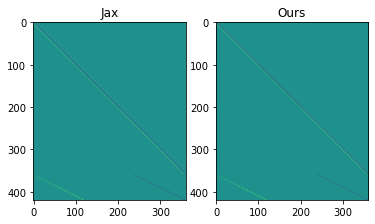

In [44]:
frobNorm(myJ, inbuiltJ, 'Ours', 'Jax')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(inbuiltJ)
ax[0].set_title('Jax')
ax[1].imshow(myJ)
ax[1].set_title('Ours')
plt.show()

In [17]:
def trajPlot(noisy, opt):
    gtVerts = np.array(readVertex('../data/gt.txt'))
    
    ax = plt.subplot(111)
    draw(gtVerts[1], gtVerts[2], gtVerts[3], ax)    
    draw(noisy[1], noisy[2], noisy[3], ax, 'r->')    
    draw(opt[0], opt[1], opt[2], ax, 'b->')    
    plt.legend(['Noisy', 'Optimized', 'Ground Truth'])
    plt.show()

In [54]:
##### LM formulation
def LM(input_contraints, omega, num_iter=100, lamb=1, errPlot=False):
    verts, initInd, edges, anchor = input_contraints
    params = verts[1:, :].flatten('F')
    #inbuiltj = findJacobian(params, initInd, edges)
        
    for i in range(num_iter):
        # caluclate f(x) and J(x)
        #J = inbuiltj(params)
        Jp = myJacob(params, initInd, edges)
        fp = findObjectiveFunction(params, initInd, edges, anchor)
            
        F = 0.5 * fp.T @ omega @ fp
        print("Error at iteration {} = {}".format(i + 1, F))
        if((i + 1) % 10 == 0):
            trajPlot(verts, jnp.reshape(params, (3, -1), 'F'))
        if errPlot:
            errs.append(F)
        
        # calculate delta X
        A = Jp.T @ omega @ Jp + lamb * np.identity(Jp.shape[1])
        B = -Jp.T @ omega.T @ fp
        del_P = np.linalg.inv(A) @ B
        # update step
        params += del_P
    
    return jnp.reshape(params, (3, -1), 'F')

Error at iteration 1 = 639372.0
Error at iteration 2 = 90723.7109375
Error at iteration 3 = 5202.15234375
Error at iteration 4 = 2736.83984375
Error at iteration 5 = 1775.7540283203125
Error at iteration 6 = 1391.3121337890625
Error at iteration 7 = 1157.5789794921875
Error at iteration 8 = 1039.3193359375
Error at iteration 9 = 966.1724243164062
Error at iteration 10 = 912.232421875


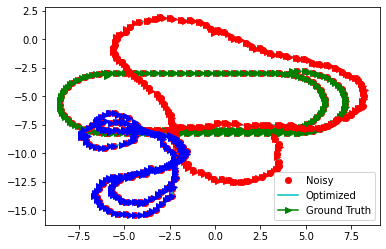

Error at iteration 11 = 869.1288452148438
Error at iteration 12 = 833.5588989257812
Error at iteration 13 = 803.8603515625
Error at iteration 14 = 778.9515991210938
Error at iteration 15 = 757.9547729492188
Error at iteration 16 = 740.08349609375
Error at iteration 17 = 724.6264038085938
Error at iteration 18 = 710.982421875
Error at iteration 19 = 698.681640625
Error at iteration 20 = 687.3805541992188


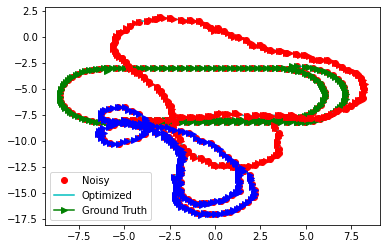

Error at iteration 21 = 676.8425903320312
Error at iteration 22 = 666.9127197265625
Error at iteration 23 = 657.48828125
Error at iteration 24 = 648.5038452148438
Error at iteration 25 = 639.9130859375
Error at iteration 26 = 631.683349609375
Error at iteration 27 = 623.7919921875
Error at iteration 28 = 616.21875
Error at iteration 29 = 608.9468994140625
Error at iteration 30 = 601.9638061523438


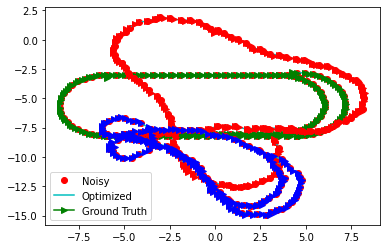

Error at iteration 31 = 595.25732421875
Error at iteration 32 = 588.8154907226562
Error at iteration 33 = 582.6286010742188
Error at iteration 34 = 576.6851806640625
Error at iteration 35 = 570.9789428710938
Error at iteration 36 = 565.4989624023438
Error at iteration 37 = 560.2381591796875
Error at iteration 38 = 555.1881713867188
Error at iteration 39 = 550.342041015625
Error at iteration 40 = 545.69140625


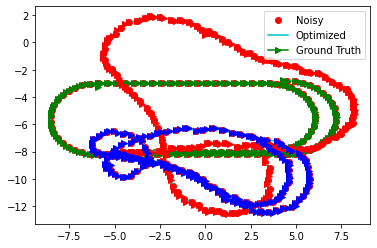

Error at iteration 41 = 541.2298583984375
Error at iteration 42 = 536.9502563476562
Error at iteration 43 = 532.845703125
Error at iteration 44 = 528.91064453125
Error at iteration 45 = 525.138427734375
Error at iteration 46 = 521.5234985351562
Error at iteration 47 = 518.059326171875
Error at iteration 48 = 514.7401733398438
Error at iteration 49 = 511.56182861328125
Error at iteration 50 = 508.5177307128906


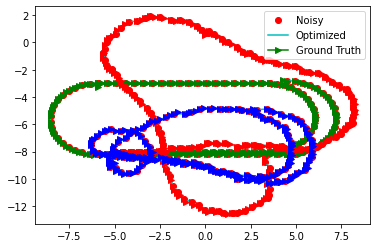

Error at iteration 51 = 505.60357666015625
Error at iteration 52 = 502.8138122558594
Error at iteration 53 = 500.1441650390625
Error at iteration 54 = 497.58966064453125
Error at iteration 55 = 495.14599609375
Error at iteration 56 = 492.8086853027344
Error at iteration 57 = 490.5732116699219
Error at iteration 58 = 488.43634033203125
Error at iteration 59 = 486.39349365234375
Error at iteration 60 = 484.4410705566406


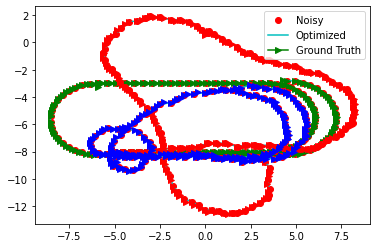

Error at iteration 61 = 482.5753173828125
Error at iteration 62 = 480.7925720214844
Error at iteration 63 = 479.089599609375
Error at iteration 64 = 477.4632873535156
Error at iteration 65 = 475.9100341796875
Error at iteration 66 = 474.4270935058594
Error at iteration 67 = 473.0118713378906
Error at iteration 68 = 471.6604309082031
Error at iteration 69 = 470.3706970214844
Error at iteration 70 = 469.1405944824219


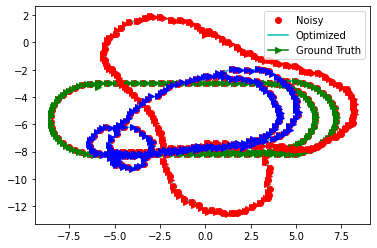

Error at iteration 71 = 467.966552734375
Error at iteration 72 = 466.8465881347656
Error at iteration 73 = 465.77838134765625
Error at iteration 74 = 464.7594299316406
Error at iteration 75 = 463.7883605957031
Error at iteration 76 = 462.8624267578125
Error at iteration 77 = 461.9791564941406
Error at iteration 78 = 461.1377258300781
Error at iteration 79 = 460.3353576660156
Error at iteration 80 = 459.5715026855469


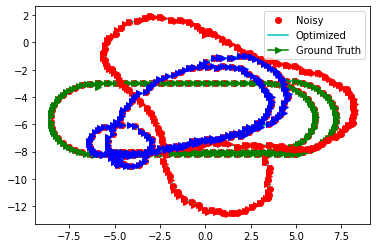

Error at iteration 81 = 458.8429870605469
Error at iteration 82 = 458.1490783691406
Error at iteration 83 = 457.4878845214844
Error at iteration 84 = 456.85784912109375
Error at iteration 85 = 456.2582702636719
Error at iteration 86 = 455.68707275390625
Error at iteration 87 = 455.1430969238281
Error at iteration 88 = 454.6252136230469
Error at iteration 89 = 454.1319885253906
Error at iteration 90 = 453.6627197265625


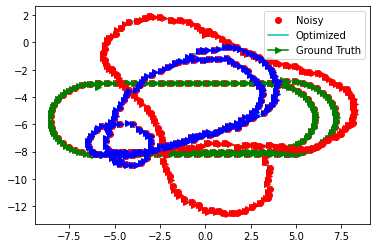

Error at iteration 91 = 453.2156982421875
Error at iteration 92 = 452.7904357910156
Error at iteration 93 = 452.38543701171875
Error at iteration 94 = 452.000244140625
Error at iteration 95 = 451.63336181640625
Error at iteration 96 = 451.28466796875
Error at iteration 97 = 450.9530334472656
Error at iteration 98 = 450.63690185546875
Error at iteration 99 = 450.3365783691406
Error at iteration 100 = 450.0506591796875


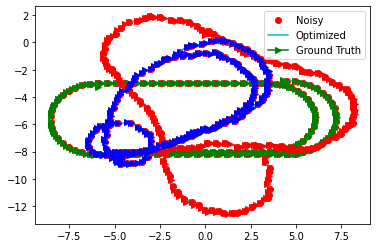

In [20]:
# LM formulation
optPoses = LM([poses, initInd, edges, anchor], getOmega())

Error at iteration 1 = 913388.75
Error at iteration 2 = 112501.734375
Error at iteration 3 = 2537.3017578125
Error at iteration 4 = 791.988037109375
Error at iteration 5 = 676.5796508789062
Error at iteration 6 = 605.895263671875
Error at iteration 7 = 551.5421752929688
Error at iteration 8 = 507.33160400390625
Error at iteration 9 = 470.3475036621094
Error at iteration 10 = 438.64898681640625


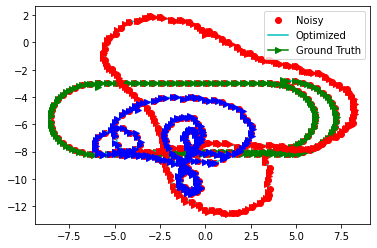

Error at iteration 11 = 410.64117431640625
Error at iteration 12 = 385.21209716796875
Error at iteration 13 = 361.755615234375
Error at iteration 14 = 340.04718017578125
Error at iteration 15 = 320.1083984375
Error at iteration 16 = 302.0790710449219
Error at iteration 17 = 286.09747314453125
Error at iteration 18 = 272.208984375
Error at iteration 19 = 260.3216857910156
Error at iteration 20 = 250.22357177734375


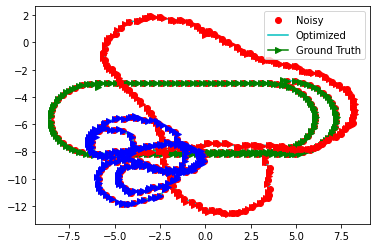

Error at iteration 21 = 241.63247680664062
Error at iteration 22 = 234.25474548339844
Error at iteration 23 = 227.82359313964844
Error at iteration 24 = 222.1211395263672
Error at iteration 25 = 216.98089599609375
Error at iteration 26 = 212.28025817871094
Error at iteration 27 = 207.9331817626953
Error at iteration 28 = 203.87911987304688
Error at iteration 29 = 200.0757598876953
Error at iteration 30 = 196.49330139160156


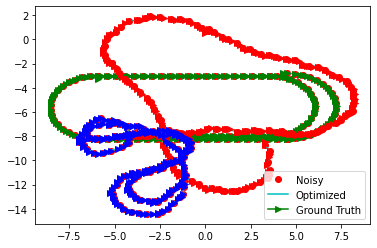

Error at iteration 31 = 193.11007690429688
Error at iteration 32 = 189.91006469726562
Error at iteration 33 = 186.8806915283203
Error at iteration 34 = 184.01165771484375
Error at iteration 35 = 181.29547119140625
Error at iteration 36 = 178.7245635986328
Error at iteration 37 = 176.29261779785156
Error at iteration 38 = 173.99423217773438
Error at iteration 39 = 171.82395935058594
Error at iteration 40 = 169.7769012451172


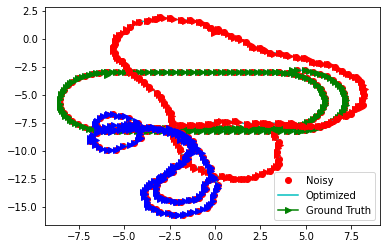

Error at iteration 41 = 167.84783935546875
Error at iteration 42 = 166.03184509277344
Error at iteration 43 = 164.32391357421875
Error at iteration 44 = 162.7191925048828
Error at iteration 45 = 161.2123565673828
Error at iteration 46 = 159.79803466796875
Error at iteration 47 = 158.47103881835938
Error at iteration 48 = 157.2257537841797
Error at iteration 49 = 156.056640625
Error at iteration 50 = 154.95852661132812


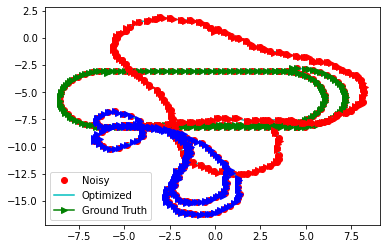

Error at iteration 51 = 153.9258575439453
Error at iteration 52 = 152.9535369873047
Error at iteration 53 = 152.03602600097656
Error at iteration 54 = 151.1689910888672
Error at iteration 55 = 150.34707641601562
Error at iteration 56 = 149.56634521484375
Error at iteration 57 = 148.822998046875
Error at iteration 58 = 148.11257934570312
Error at iteration 59 = 147.4321746826172
Error at iteration 60 = 146.77847290039062


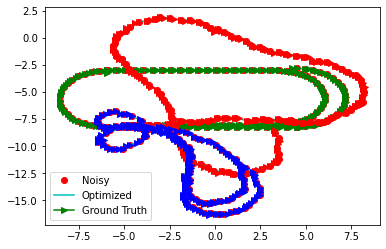

Error at iteration 61 = 146.1484832763672
Error at iteration 62 = 145.54013061523438
Error at iteration 63 = 144.95077514648438
Error at iteration 64 = 144.3786163330078
Error at iteration 65 = 143.82217407226562
Error at iteration 66 = 143.2794189453125
Error at iteration 67 = 142.7493438720703
Error at iteration 68 = 142.2310028076172
Error at iteration 69 = 141.72274780273438
Error at iteration 70 = 141.2244415283203


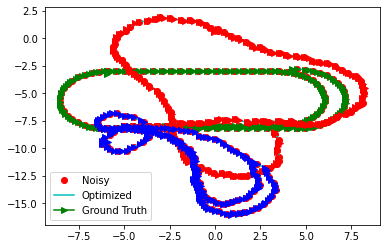

Error at iteration 71 = 140.7346954345703
Error at iteration 72 = 140.25341796875
Error at iteration 73 = 139.77981567382812
Error at iteration 74 = 139.31338500976562
Error at iteration 75 = 138.85369873046875
Error at iteration 76 = 138.4005126953125
Error at iteration 77 = 137.9530792236328
Error at iteration 78 = 137.51170349121094
Error at iteration 79 = 137.07574462890625
Error at iteration 80 = 136.64527893066406


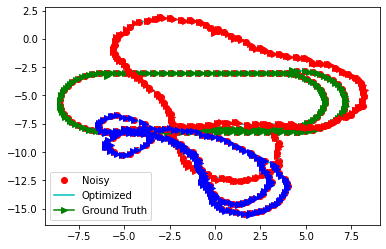

Error at iteration 81 = 136.21961975097656
Error at iteration 82 = 135.7989501953125
Error at iteration 83 = 135.38320922851562
Error at iteration 84 = 134.97206115722656
Error at iteration 85 = 134.56546020507812
Error at iteration 86 = 134.1630096435547
Error at iteration 87 = 133.76502990722656
Error at iteration 88 = 133.37110900878906
Error at iteration 89 = 132.9812469482422
Error at iteration 90 = 132.59547424316406


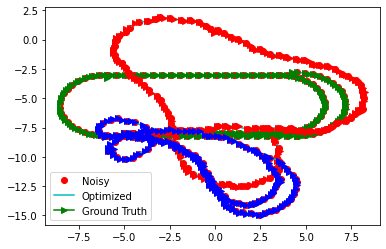

Error at iteration 91 = 132.21372985839844
Error at iteration 92 = 131.835693359375
Error at iteration 93 = 131.46142578125
Error at iteration 94 = 131.09112548828125
Error at iteration 95 = 130.7243194580078
Error at iteration 96 = 130.3610382080078
Error at iteration 97 = 130.00143432617188
Error at iteration 98 = 129.6453094482422
Error at iteration 99 = 129.2925567626953
Error at iteration 100 = 128.94322204589844


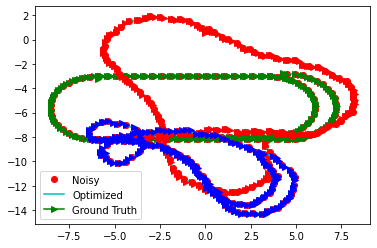

In [24]:
optPoses = LM([poses, initInd, edges, anchor], getOmega([100, 1000, 2000]))

Error at iteration 1 = 548033.125
Error at iteration 2 = 77128.4296875
Error at iteration 3 = 1206.1849365234375
Error at iteration 4 = 449.4898986816406
Error at iteration 5 = 386.57135009765625
Error at iteration 6 = 355.1557312011719
Error at iteration 7 = 331.9083251953125
Error at iteration 8 = 313.1273498535156
Error at iteration 9 = 297.1318054199219
Error at iteration 10 = 283.1423034667969


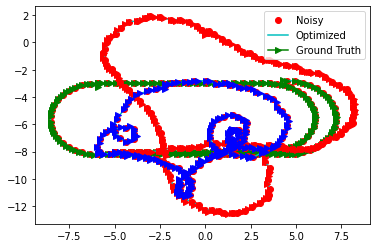

Error at iteration 11 = 270.76776123046875
Error at iteration 12 = 259.772705078125
Error at iteration 13 = 249.96775817871094
Error at iteration 14 = 241.1671600341797
Error at iteration 15 = 233.18577575683594
Error at iteration 16 = 225.85716247558594
Error at iteration 17 = 219.0433807373047
Error at iteration 18 = 212.63827514648438
Error at iteration 19 = 206.5625762939453
Error at iteration 20 = 200.7588348388672


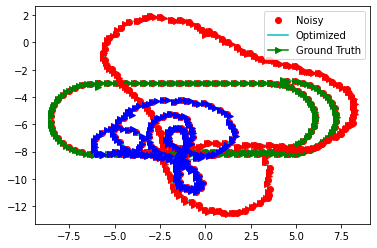

Error at iteration 21 = 195.1864471435547
Error at iteration 22 = 189.81680297851562
Error at iteration 23 = 184.63172912597656
Error at iteration 24 = 179.62132263183594
Error at iteration 25 = 174.78138732910156
Error at iteration 26 = 170.11276245117188
Error at iteration 27 = 165.62063598632812
Error at iteration 28 = 161.31137084960938
Error at iteration 29 = 157.19337463378906
Error at iteration 30 = 153.27398681640625


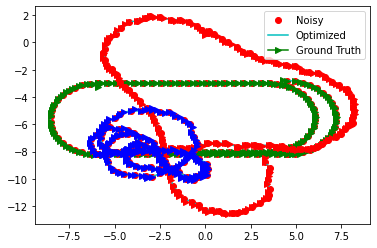

Error at iteration 31 = 149.55978393554688
Error at iteration 32 = 146.0548858642578
Error at iteration 33 = 142.76048278808594
Error at iteration 34 = 139.67466735839844
Error at iteration 35 = 136.7925262451172
Error at iteration 36 = 134.1058349609375
Error at iteration 37 = 131.60450744628906
Error at iteration 38 = 129.27662658691406
Error at iteration 39 = 127.10848999023438
Error at iteration 40 = 125.08647155761719


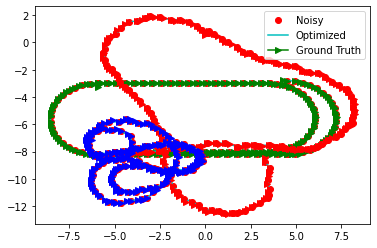

Error at iteration 41 = 123.19664001464844
Error at iteration 42 = 121.42559814453125
Error at iteration 43 = 119.76040649414062
Error at iteration 44 = 118.18960571289062
Error at iteration 45 = 116.70233917236328
Error at iteration 46 = 115.28934478759766
Error at iteration 47 = 113.94230651855469
Error at iteration 48 = 112.65401458740234
Error at iteration 49 = 111.41841888427734
Error at iteration 50 = 110.2300796508789


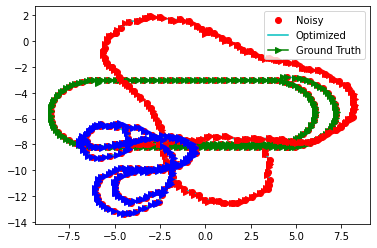

Error at iteration 51 = 109.08477783203125
Error at iteration 52 = 107.97868347167969
Error at iteration 53 = 106.90869903564453
Error at iteration 54 = 105.8720932006836
Error at iteration 55 = 104.86669921875
Error at iteration 56 = 103.89060974121094
Error at iteration 57 = 102.9424057006836
Error at iteration 58 = 102.02046203613281
Error at iteration 59 = 101.12367248535156
Error at iteration 60 = 100.25094604492188


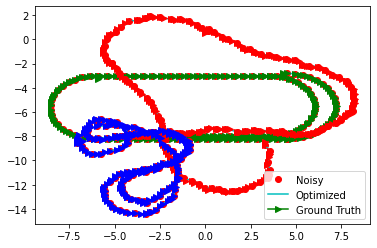

Error at iteration 61 = 99.40158081054688
Error at iteration 62 = 98.57463073730469
Error at iteration 63 = 97.76930236816406
Error at iteration 64 = 96.98511505126953
Error at iteration 65 = 96.22138977050781
Error at iteration 66 = 95.47761535644531
Error at iteration 67 = 94.75322723388672
Error at iteration 68 = 94.0478286743164
Error at iteration 69 = 93.36090850830078
Error at iteration 70 = 92.692138671875


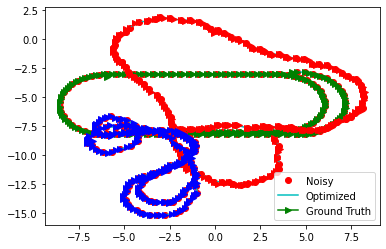

Error at iteration 71 = 92.04103088378906
Error at iteration 72 = 91.40727996826172
Error at iteration 73 = 90.7906265258789
Error at iteration 74 = 90.1905288696289
Error at iteration 75 = 89.60667419433594
Error at iteration 76 = 89.03881072998047
Error at iteration 77 = 88.486572265625
Error at iteration 78 = 87.9496841430664
Error at iteration 79 = 87.42779541015625
Error at iteration 80 = 86.92070770263672


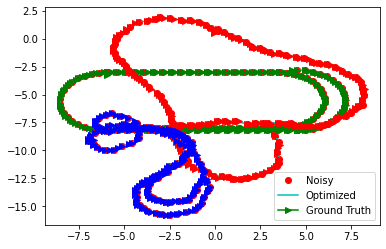

Error at iteration 81 = 86.42790222167969
Error at iteration 82 = 85.94903564453125
Error at iteration 83 = 85.48416137695312
Error at iteration 84 = 85.03260803222656
Error at iteration 85 = 84.59424591064453
Error at iteration 86 = 84.16868591308594
Error at iteration 87 = 83.75565338134766
Error at iteration 88 = 83.35480499267578
Error at iteration 89 = 82.96578216552734
Error at iteration 90 = 82.58832550048828


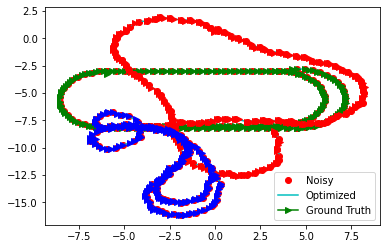

Error at iteration 91 = 82.22213745117188
Error at iteration 92 = 81.86675262451172
Error at iteration 93 = 81.52201080322266
Error at iteration 94 = 81.18756866455078
Error at iteration 95 = 80.8629379272461
Error at iteration 96 = 80.54795837402344
Error at iteration 97 = 80.24221801757812
Error at iteration 98 = 79.9453353881836
Error at iteration 99 = 79.65715789794922
Error at iteration 100 = 79.37724304199219


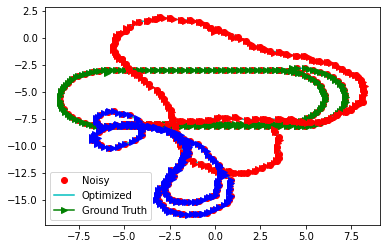

In [29]:
optPoses = LM([poses, initInd, edges, anchor], getOmega([50, 600, 1500]))

Error at iteration 1 = 45669.421875
Error at iteration 2 = 8183.04150390625
Error at iteration 3 = 311.5025939941406
Error at iteration 4 = 186.84432983398438
Error at iteration 5 = 127.77723693847656
Error at iteration 6 = 105.48075866699219
Error at iteration 7 = 96.57725524902344
Error at iteration 8 = 91.40372467041016
Error at iteration 9 = 87.60070037841797
Error at iteration 10 = 84.50054931640625


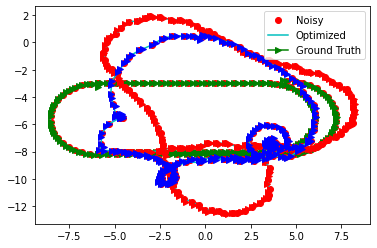

Error at iteration 11 = 81.86051940917969
Error at iteration 12 = 79.5681381225586
Error at iteration 13 = 77.55744934082031
Error at iteration 14 = 75.77962493896484
Error at iteration 15 = 74.19278717041016
Error at iteration 16 = 72.76084899902344
Error at iteration 17 = 71.45392608642578
Error at iteration 18 = 70.24844360351562
Error at iteration 19 = 69.1264877319336
Error at iteration 20 = 68.07440948486328


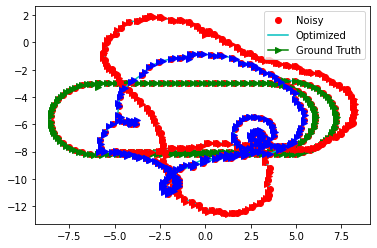

Error at iteration 21 = 67.08177185058594
Error at iteration 22 = 66.14069366455078
Error at iteration 23 = 65.2447738647461
Error at iteration 24 = 64.38906860351562
Error at iteration 25 = 63.56938552856445
Error at iteration 26 = 62.782413482666016
Error at iteration 27 = 62.02525329589844
Error at iteration 28 = 61.29574203491211
Error at iteration 29 = 60.59177780151367
Error at iteration 30 = 59.91179656982422


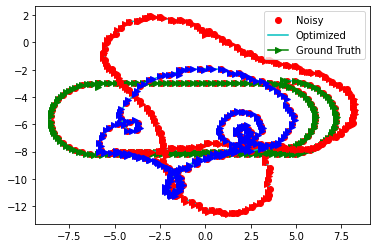

Error at iteration 31 = 59.25446701049805
Error at iteration 32 = 58.6186637878418
Error at iteration 33 = 58.003334045410156
Error at iteration 34 = 57.40775680541992
Error at iteration 35 = 56.8311767578125
Error at iteration 36 = 56.273075103759766
Error at iteration 37 = 55.73282241821289
Error at iteration 38 = 55.20990753173828
Error at iteration 39 = 54.703948974609375
Error at iteration 40 = 54.21437072753906


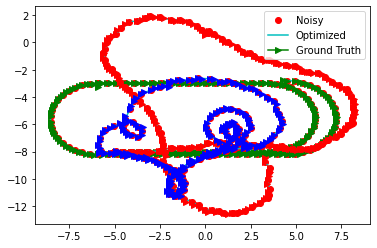

Error at iteration 41 = 53.74069595336914
Error at iteration 42 = 53.282474517822266
Error at iteration 43 = 52.83909606933594
Error at iteration 44 = 52.41009521484375
Error at iteration 45 = 51.994873046875
Error at iteration 46 = 51.59285354614258
Error at iteration 47 = 51.203433990478516
Error at iteration 48 = 50.82603073120117
Error at iteration 49 = 50.460060119628906
Error at iteration 50 = 50.10493469238281


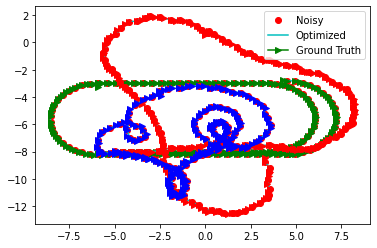

Error at iteration 51 = 49.76010513305664
Error at iteration 52 = 49.4249267578125
Error at iteration 53 = 49.09897994995117
Error at iteration 54 = 48.78165054321289
Error at iteration 55 = 48.4725456237793
Error at iteration 56 = 48.171142578125
Error at iteration 57 = 47.87703323364258
Error at iteration 58 = 47.589744567871094
Error at iteration 59 = 47.30896759033203
Error at iteration 60 = 47.03429412841797


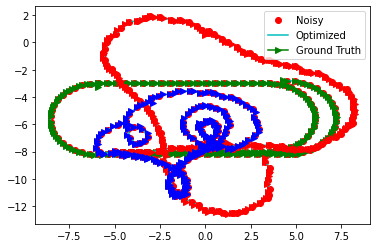

Error at iteration 61 = 46.7653923034668
Error at iteration 62 = 46.50200271606445
Error at iteration 63 = 46.243736267089844
Error at iteration 64 = 45.9903564453125
Error at iteration 65 = 45.74165344238281
Error at iteration 66 = 45.497379302978516
Error at iteration 67 = 45.25728225708008
Error at iteration 68 = 45.021156311035156
Error at iteration 69 = 44.788875579833984
Error at iteration 70 = 44.56017303466797


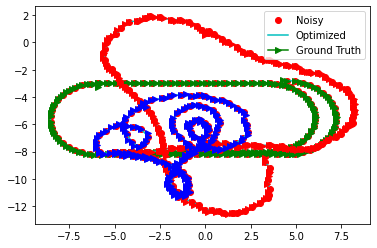

Error at iteration 71 = 44.33494186401367
Error at iteration 72 = 44.1130485534668
Error at iteration 73 = 43.89427947998047
Error at iteration 74 = 43.67855453491211
Error at iteration 75 = 43.4657096862793
Error at iteration 76 = 43.25566482543945
Error at iteration 77 = 43.04826354980469
Error at iteration 78 = 42.84347152709961
Error at iteration 79 = 42.64113998413086
Error at iteration 80 = 42.4411506652832


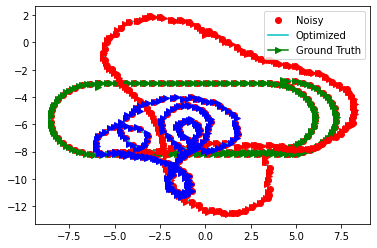

Error at iteration 81 = 42.243446350097656
Error at iteration 82 = 42.0479736328125
Error at iteration 83 = 41.854618072509766
Error at iteration 84 = 41.663291931152344
Error at iteration 85 = 41.473976135253906
Error at iteration 86 = 41.28654861450195
Error at iteration 87 = 41.101009368896484
Error at iteration 88 = 40.91725158691406
Error at iteration 89 = 40.7352180480957
Error at iteration 90 = 40.554893493652344


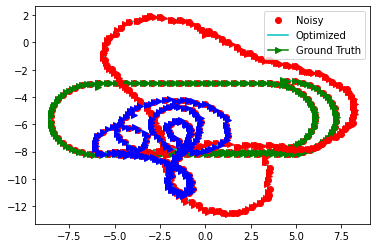

Error at iteration 91 = 40.376224517822266
Error at iteration 92 = 40.19904708862305
Error at iteration 93 = 40.02351379394531
Error at iteration 94 = 39.849449157714844
Error at iteration 95 = 39.67683029174805
Error at iteration 96 = 39.5056037902832
Error at iteration 97 = 39.33583068847656
Error at iteration 98 = 39.167335510253906
Error at iteration 99 = 39.000179290771484
Error at iteration 100 = 38.834312438964844


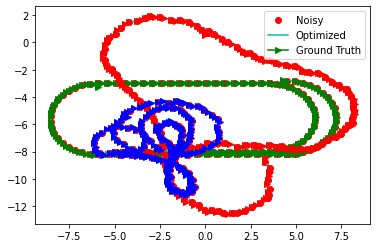

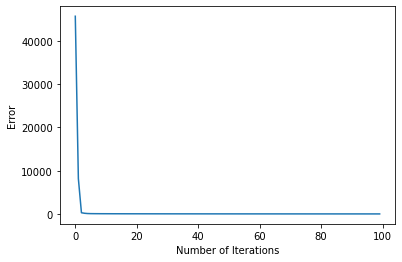

In [56]:
errs = []
optPoses = LM([poses, initInd, edges, anchor], getOmega([10, 50, 100]), errPlot=True)

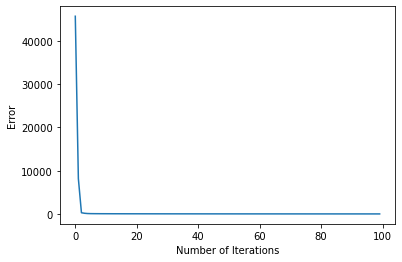

In [58]:
plt.plot(range(100), errs)
plt.xlabel("Number of Iterations")
plt.ylabel("Error")
plt.show()

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Residuals

The shape of the residuals turns out to be 420 = 3 * (1 + numOdo + numLoop) where 1 is for the anchor constraint (to anchor pose 0 as per original value given), numOdo is for the number of odometery constraints/edges and numLoop is for the number of loop constraints/edges. We multiply by 3 as there are 3 parameters of x, y and theta for each equation/constraint. The residuals order/shape is in the format:
* First 3 rows/elements for the anchor constraint on pose 0 in the order of x, y and theta
* Next 3 * numOdo rows/elements for the odometery constraints, with 3 consecutive rows for each constraint/edge in the order of x, y and theta
* Final 3 * numLoop rows/elements for the loop constraints, with 3 consecutive rows for each constraint/edge in the order of x, y and theta

## Jacobian

The Jacobian shape turns out to be 420 x 360 = [3 * (1 + numOdo + numLoop)] x [3 * numPoses] where the number of rows explanation can be understood the same as for the residuals mentioned above. For the columns, numPoses is the number of poses/vertices (120) and we multiply by 3 as each pose has 3 parameters of x, y and theta which are to be optimized. Here the rows follow the same structure/order as the residuals mentioned above while the columns follow the order of the poses (from 0 - 119) with 3 consecutive columns per pose in the order of x<sub>i</sub>, y<sub>i</sub> and theta<sub>i</sub> (here i refers to pose index/number). Essentially, the Jacobian is calculated by taking the partial derivative of the residuals [3 * (1 + numOdo + numLoop)] with respect to all the parameters [3 * numPoses] and stacking them up.

## Optimization

Given the non-linear format of the optimization, it is very volatile to changes in hyperparameters and initialization. Here, the initialization is fixed in terms of the edges and the initial estimate of the poses but the hyperparameters were played around with. Mainly, the information matrix seemed to have a significant effect on the results.

The information matrix essentially encodes the confidence we have in each constraint. This means that the greater the value/weight given to a constraint, the greater the confidence/importance given to optimizing that constraint as heavier penalty is applied for deviating from that constraint. We have given greater weights to loop closure constraints as these are generally more reliable and accurate than odometery constraints and are relying on these constraints to optimize the estimates obtained from odometery itself, thus increasing the need for these. We have assigned even heavier weights to anchoring constraints as we have absolute confidence (virtually no error/doubt) in these constraints. In accordance with the above rules, we played around with the 3 kinds of weights and have shown the results for some of these experiments above.

We found that while the loop and anchor constraints did have to be larger than the odometery ones, they shouldn't be too large as then this would undermine the odometery constraints heavily and while the shape and starting point may still turn out to be relatively accurate, the poses' locations may be off by quite a margin, rendering the error fairly big.

We also observed that initially the error reduces drastically with each step for most cases (irrespective of hyperparameters), but eventually it begins slowing down and within 70-100 loops seems to converge to a local minimum as the changes in error are minimal/insignificant thereafter. This can be seen in the error plot given above.

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [57]:
g2oWrite('../results/opt-poses.g2o', '../data/edges.txt', optPoses)